In [1]:
import tensorflow as tf
from tensorflow.python.ops.rnn import _transpose_batch_time

from datetime import datetime
import numpy as np
import pandas as pd
import glob, os, sys, math, warnings, copy, time, glob, pickle
import matplotlib.pyplot as plt
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"

# customized ftns 
from preprocessing import *
from sequencing import get_sequences, get_minibatches, iterate_minibatches, subsample_sequence
from utilities import *
from model import *
from train import train_all_single_policies
# ---------------------------------------------------------
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# ---------------------------------------------------------
# directories
main_dir = '../'
game_dir = main_dir+'data/'
Data = LoadData(main_dir, game_dir)
models_path = './models/' 

/home/sam/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/sam/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Pre-process 
filter events, subsample frames, add velocity, reorder moments, re-arrange team order
shot clock, filter out event with short moments; also hidden role learning

In [2]:
# all game ids file name
all_games_id = [i.split('/')[-1].split('.')[0] for i in glob.glob('../data/*.pkl')]

In [3]:
# all_games_id = all_games_id[:3]

In [4]:
# event with frames less than the threshold will be removed
event_threshold = 100
# since 25 frames/sec is probably too much so downsample by two
subsample_factor = 2
# save the processed file to disk to avoid repeated work
game_files = './all_games_{0}_{1}_{2}.pkl'.format(len(all_games_id), event_threshold, subsample_factor)
if os.path.isfile(game_files):
    with open(game_files, 'rb') as f:
        game_data = pickle.load(f)
else:
    game_data = process_game_data(Data, all_games_id, event_threshold, subsample_factor)
    with open(game_files, 'wb') as f:
        pickle.dump(game_data, f)
print('Final number of events:', len(game_data))

2018-05-29 23:07:30,628 | INFO : working on game 0021500066 | 1 out of total 42 games
2018-05-29 23:07:51,002 | INFO : working on game 0021500529 | 2 out of total 42 games
2018-05-29 23:08:10,754 | INFO : working on game 0021500042 | 3 out of total 42 games
2018-05-29 23:08:27,576 | INFO : working on game 0021500115 | 4 out of total 42 games
2018-05-29 23:08:47,819 | INFO : working on game 0021500096 | 5 out of total 42 games
2018-05-29 23:09:10,341 | INFO : working on game 0021500649 | 6 out of total 42 games
2018-05-29 23:09:28,777 | INFO : working on game 0021500383 | 7 out of total 42 games
2018-05-29 23:09:53,380 | INFO : working on game 0021500272 | 8 out of total 42 games
2018-05-29 23:10:12,125 | INFO : working on game 0021500075 | 9 out of total 42 games
2018-05-29 23:10:29,816 | INFO : working on game 0021500355 | 10 out of total 42 games
2018-05-29 23:10:53,249 | INFO : working on game 0021500421 | 11 out of total 42 games
2018-05-29 23:11:17,657 | INFO : working on game 002

         1  -169724388.5778             +nan
         2  -147823214.3897   +21901174.1881
         3  -142410113.7409    +5413100.6488
         4  -141242212.0875    +1167901.6534
         5  -140517954.4937     +724257.5938
         6  -139917415.6611     +600538.8326
         7  -139549793.8034     +367621.8577
         8  -139299729.1151     +250064.6883
         9  -139119939.6876     +179789.4275
        10  -139001026.6960     +118912.9917
        11  -138924595.8095      +76430.8864
        12  -138875215.8216      +49379.9879
        13  -138841163.5742      +34052.2475
        14  -138817312.1466      +23851.4276
        15  -138799686.1249      +17626.0217
        16  -138785914.7344      +13771.3905
        17  -138774300.2092      +11614.5252
        18  -138764126.0092      +10174.2000
        19  -138754534.4640       +9591.5452
        20  -138744864.4392       +9670.0249
        21  -138734365.4461      +10498.9931
        22  -138721986.9518      +12378.4943
        23

2018-05-30 00:41:49,444 | INFO : Assigning roles by cosine method.
2018-05-30 00:41:49,445 | INFO : Training for player_inds: [5, 6, 7, 8, 9] with iterations: 1000


         1  -184791489.4785             +nan
         2  -157711793.9455   +27079695.5330
         3  -152663993.4817    +5047800.4638
         4  -152032760.6717     +631232.8100
         5  -151775921.3740     +256839.2977
         6  -151576813.8406     +199107.5334
         7  -151414960.9051     +161852.9355
         8  -151277234.4549     +137726.4502
         9  -151155492.4309     +121742.0240
        10  -151049890.3215     +105602.1094
        11  -150958873.9815      +91016.3401
        12  -150882386.9971      +76486.9843
        13  -150820345.7043      +62041.2929
        14  -150773539.6066      +46806.0977
        15  -150738057.7623      +35481.8443
        16  -150711180.0121      +26877.7502
        17  -150690349.5805      +20830.4316
        18  -150673318.0010      +17031.5795
        19  -150659110.2262      +14207.7747
        20  -150647110.3465      +11999.8797
        21  -150636310.4056      +10799.9410
        22  -150627014.1759       +9296.2297
        23

2018-05-30 02:08:37,336 | INFO : Total HMM training took 166.63mins
Final number of events: 6485


### Show the plot, for the sake of comparison with processed moment later on

In [5]:
# choose a game id for a quick plot
game_id = all_games_id[0]
Plot = PlotGame(game_id, main_dir, game_dir)

In [6]:
plt_ind = 0

0


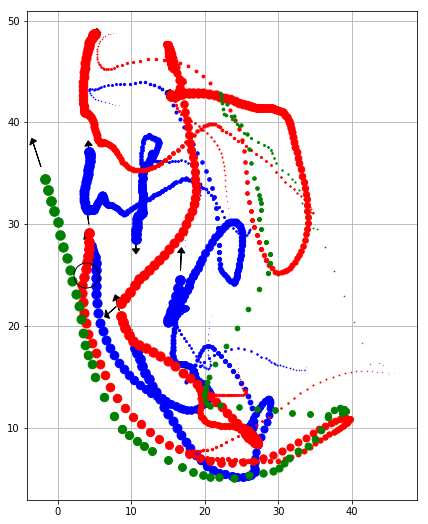

In [7]:
# manual plot check
print(plt_ind)
plot_check(game_data, plt_ind)
plt_ind += 1

#### Build graph and starts training for all single policies (in total five)

In [8]:
# Build graph and starts training for all single policies
sequence_length = 50
overlap = 25
batch_size = 128

hyper_params = {'use_model': 'dynamic_rnn_layer_norm',
                'train_percentage': 0.85,
                'batch_size': batch_size,
                'sequence_length': sequence_length,
                'overlap': overlap,
                'state_size': [128, 128],
                'use_peepholes': None,
                'input_dim': 179,
                'dropout_rate': 0.6,
                'learning_rate': 0.0005,
                'n_epoch': int(5e3),
                'printn': int(5e2),
                'policies': [0],
                'horizons': [0]}

train_all_single_policies(game_data, hyper_params, models_path)

2018-05-30 02:11:10,023 | INFO : Training with setup: 
{'use_model': 'dynamic_rnn_layer_norm', 'train_percentage': 0.85, 'batch_size': 128, 'sequence_length': 50, 'overlap': 25, 'state_size': [128, 128], 'use_peepholes': None, 'input_dim': 179, 'dropout_rate': 0.6, 'learning_rate': 0.0005, 'n_epoch': 5000, 'printn': 500, 'policies': [0], 'horizons': [0]}
2018-05-30 02:11:10,024 | INFO : Wroking on policy 0
2018-05-30 02:11:10,717 | INFO : train len: 21830 | test shape: 3853
2018-05-30 02:11:12,949 | INFO : Horizon 0 ==========
2018-05-30 02:11:30,892 | INFO : Epoch 0    | loss: 361.23   | time took: 17.15s | validation loss: 270.06  
2018-05-30 04:32:20,177 | INFO : Epoch 500  | loss: 0.84     | time took: 16.89s | validation loss: 1.60    
2018-05-30 06:53:09,438 | INFO : Epoch 1000 | loss: 0.43     | time took: 16.89s | validation loss: 1.34    
2018-05-30 09:14:03,120 | INFO : Epoch 1500 | loss: 0.31     | time took: 16.91s | validation loss: 1.45    
2018-05-30 11:34:55,727 | INFO 

### Check performance

In [9]:
# pad short sequence and chunk long sequence with overlaps
policy = 0
train, target = get_sequences(game_data, policy, sequence_length, overlap)
# create train and test set
p = 0.8 # train percentage
divider = int(len(train)*p)
train_game, test_game = np.copy(train[:divider]), np.copy(train[divider:])
train_target, test_target = np.copy(target[:divider]), np.copy(target[divider:])
Model = ImportGraph('policy0/')

./models/model


In [10]:
n = 0

### Manual plot check again

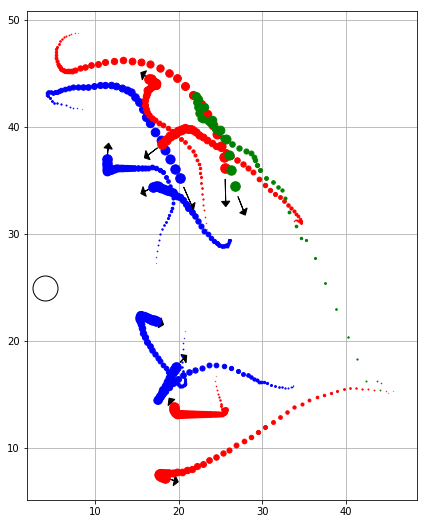

In [11]:
plot_check(train_game, n)
n+=1

#### Plot out role trajectory prediction (*green*) vs true trajectory (*blue*)
The points jumps since its not per play but per role, which could be switched around during the game

rand checking index: 91 out of 160


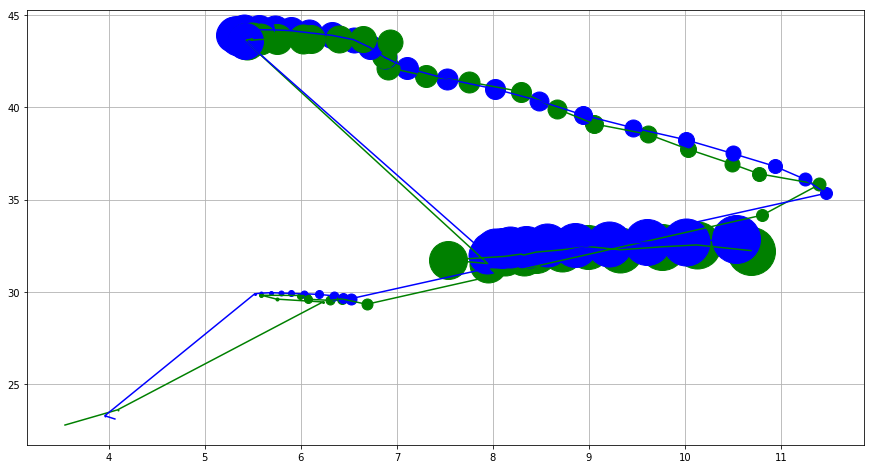

In [13]:
# use while loop to make sure the 
train_batches = get_minibatches(train_game, train_target, batch_size, shuffle=False)

check_ind = np.random.randint(0, len(train_game)//batch_size)
print('rand checking index: {0:} out of {1:}'.format(check_ind, len(train_game)//batch_size))

input_xi, output_yi = train_batches

y_pred = Model.forward_pass(input_xi[check_ind])
y_true = output_yi[check_ind]
    
y_pred = y_pred[0][0].reshape(-1,2)
y_true = y_true[0].reshape(-1,2)

plt.figure(figsize=(15,8))
for k in range(0, len(y_pred)):
    plt.plot(y_pred[:, 0][k], y_pred[:, 1][k], linestyle="None", marker="o", markersize=k, color='g')
    plt.plot(y_true[:, 0][k], y_true[:, 1][k], linestyle="None", marker="o", markersize=k, color='b')

plt.plot(y_pred[:, 0], y_pred[:, 1],'g', y_true[:,0], y_true[:,1], 'b')
plt.grid(True)

### To do:

    1) Try to see if smoothing traajectory is possible
    2) Look into end-to-end training